# Classify field photos as fog or no fog.

Author: Autumn Nguyen

Version: July 2023

In [1]:
# ! pip install scikit-image
# ! pip install plotly==5.15.0

In [3]:
import os
import glob as glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from skimage.io import imread
from skimage.transform import resize, rescale
import plotly.express as px

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Prepare training data

In [35]:
input_dir = "/Users/autumn_yngoc/Downloads/Marine Fog/Cattle Point Jul-Sep 2022 photos"
categories = ['no_fog', 'fog'] # no_fog as 0, and fog as 1

img_list = [] 
rescaled_list = []
data_list = [] # feature array
label_list = [] # target array

# Loop through the no_fog and fog folders
for category_idx, category in enumerate(categories):
    # Find all the image files
    files = glob.glob(os.path.join(input_dir, category, '*.JPG'))
    print(len(files))
    for file in files:
        # Read each image file into a 3D array of numbers
        img = imread(file)
        img_list.append(img)
        # img = resize(img, (15, 15))
        # Rescale each image into 5% resolution to reduce runtime
        rescaled_img = rescale(img, 0.05, channel_axis = 2)
        rescaled_list.append(rescaled_img)
        # flatten the 3D numpy arrays into a 1D array, and append it to the feature list
        data_list.append(rescaled_img.flatten()) 
        # Append the category index (0 for 'no_fog', and 1 for 'fog') to the target list
        label_list.append(category_idx)

40
33


In [36]:
# Convert the lists to arrays
data = np.asarray(data_list)
labels = np.asarray(label_list)

In [37]:
# Split 70/30 train/test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, stratify=labels, random_state=13)
y_test

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

## Train a model

In [38]:
classifier = SVC(probability=True)

In [39]:
parameters = [{'kernel': ['rbf', 'linear', 'poly'], 'gamma': [0.001, 0.0001, 0.00001], 'C': [5, 10, 50]}]

In [40]:
# GridSearchCV will perform an exhaustive search over all possible combinations of hyperparameters to find the optimal values
grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, cv=3, n_jobs=3, verbose=4)

grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END ......C=5, gamma=0.001, kernel=rbf;, score=0.882 total time=   0.1s
[CV 3/3] END ......C=5, gamma=0.001, kernel=rbf;, score=0.882 total time=   0.1s
[CV 2/3] END ......C=5, gamma=0.001, kernel=rbf;, score=0.941 total time=   0.2s
[CV 1/3] END ...C=5, gamma=0.001, kernel=linear;, score=0.941 total time=   0.1s
[CV 3/3] END ...C=5, gamma=0.001, kernel=linear;, score=0.941 total time=   0.1s
[CV 2/3] END ...C=5, gamma=0.001, kernel=linear;, score=0.824 total time=   0.1s
[CV 1/3] END .....C=5, gamma=0.001, kernel=poly;, score=0.882 total time=   0.1s
[CV 2/3] END .....C=5, gamma=0.001, kernel=poly;, score=0.824 total time=   0.1s
[CV 3/3] END .....C=5, gamma=0.001, kernel=poly;, score=0.941 total time=   0.1s
[CV 1/3] END .....C=5, gamma=0.0001, kernel=rbf;, score=0.824 total time=   0.1s
[CV 2/3] END .....C=5, gamma=0.0001, kernel=rbf;, score=1.000 total time=   0.1s
[CV 3/3] END .....C=5, gamma=0.0001, kernel=rbf;

GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=3,
             param_grid=[{'C': [5, 10, 50], 'gamma': [0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'linear', 'poly']}],
             verbose=4)

In [41]:
print(grid_search.best_score_)
print(grid_search.best_params_)
best_estimator = grid_search.best_estimator_

0.9411764705882352
{'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'}


In [42]:
y_train_pred = best_estimator.predict(x_train)
y_test_pred = best_estimator.predict(x_test)

train_score = accuracy_score(y_train_pred, y_train)
test_score = accuracy_score(y_test_pred, y_test)

print('{}% of training set were correctly classified'.format(str(train_score * 100)))
print('{}% of testing set were correctly classified'.format(str(test_score * 100)))

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()
print("Test: ", tn_test, fp_test, fn_test, tp_test)

96.07843137254902% of training set were correctly classified
90.9090909090909% of testing set were correctly classified
Test:  12 0 2 8


## Look closely at some of the predictions
A note about probability score: in binary classification, a sample may be labeled by predict as belonging to the positive class even if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even if the output of predict_proba is more than 0.5 (https://scikit-learn.org/stable/modules/svm.html#scores-probabilities)

Probability being no_fog = 98.15484168435574%
Probability being fog = 1.845158315644261%
The predicted image is : no_fog


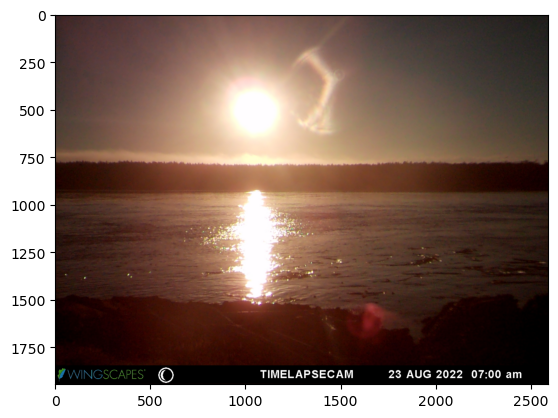

In [43]:
plt.imshow(img_list[0])
probability = best_estimator.predict_proba([data[0]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[0]])[0]])

Probability being no_fog = 93.48180712340685%
Probability being fog = 6.518192876593148%
The predicted image is : no_fog


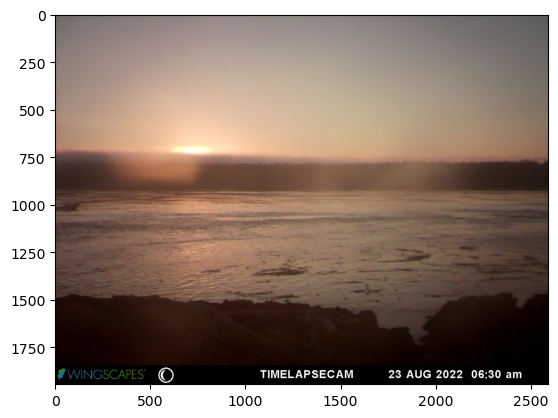

In [44]:
plt.imshow(img_list[1])
probability = best_estimator.predict_proba([data[1]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[1]])[0]])

Probability being no_fog = 96.59929577312228%
Probability being fog = 3.400704226877708%
The predicted image is : no_fog


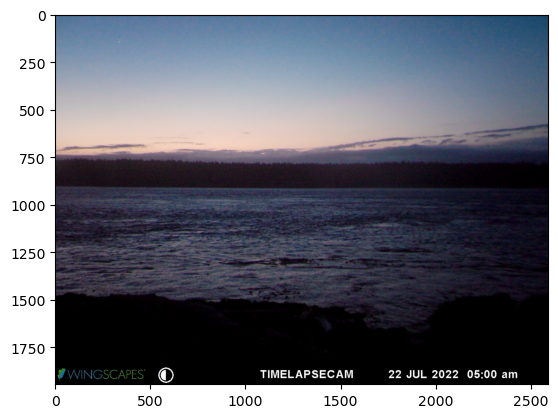

In [45]:
plt.imshow(img_list[30])
probability = best_estimator.predict_proba([data[30]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[30]])[0]])

Probability being no_fog = 1.0514157128836448%
Probability being fog = 98.94858428711635%
The predicted image is : fog


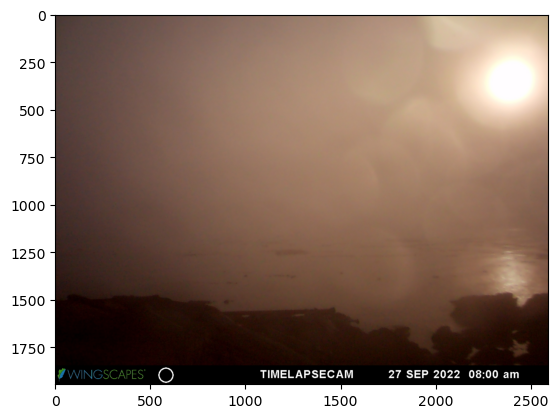

In [52]:
plt.imshow(img_list[-30])
probability = best_estimator.predict_proba([data[-30]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[-30]])[0]])

Probability being no_fog = 0.700035211377923%
Probability being fog = 99.29996478862209%
The predicted image is : fog


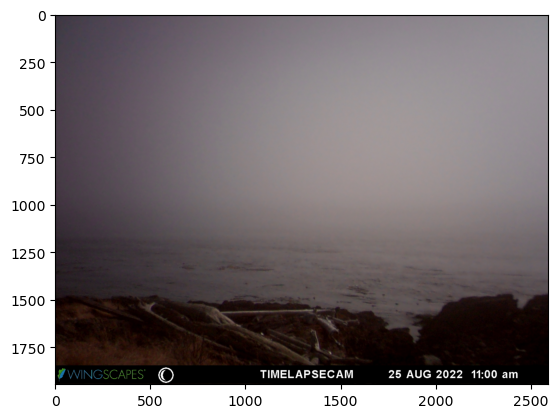

In [51]:
plt.imshow(img_list[-20])
probability = best_estimator.predict_proba([data[-20]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[-20]])[0]])

Probability being no_fog = 48.09998147411381%
Probability being fog = 51.900018525886196%
The predicted image is : no_fog


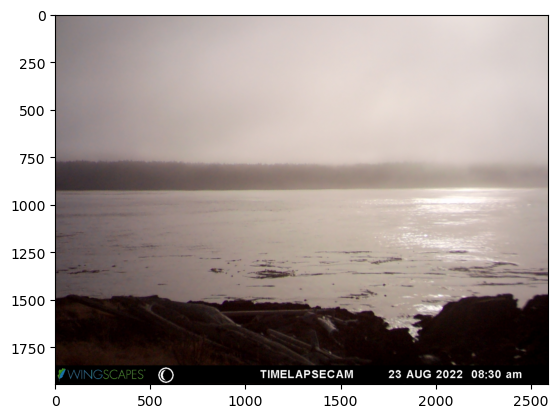

In [48]:
plt.imshow(img_list[-1])
probability = best_estimator.predict_proba([data[-1]])
for ind,val in enumerate(categories):
    print(f'Probability being {val} = {probability[0][ind]*100}%')
print("The predicted image is : "+categories[best_estimator.predict([data[-1]])[0]])

In [53]:
# Save the best model by pickling it so that we don't need ro do the training process again after restarting the notebook
pickle.dump(best_estimator, open('./cattlepoint_model.p', 'wb'))

## Use the model to predict all photos
Including the photos used for training and testing earlier, and the remaining photos in the folder to be classifed.

In [54]:
import PIL.Image

### Prepare all data for classification

In [55]:
input_dir = '/Users/autumn_yngoc/Downloads/Marine Fog/Cattle Point Jul-Sep 2022 photos/photos' # Where I store the photos on my local computer
files = glob.glob(os.path.join(input_dir, '*.JPG'))
len(files)

2429

In [56]:
# Initialize lists to create an output dataframe afterwards
x = []
names = []
paths = []
times = []

for file in files:
    paths.append(file) # file path
    names.append(file.split('/')[-1]) # file name

    # Get the array of numbers representation of the image
    img = imread(file)

    # Get the creation time from the metadata of the iamge file
    time_str = PIL.Image.open(file)._getexif()[36867]
    time = pd.to_datetime(time_str, format='%Y:%m:%d %H:%M:%S')
    times.append(time)
    
    rescaled_img = rescale(img, 0.05, channel_axis = 2).flatten()
    # Append the rescaled and flattened image array to a list 
    x.append(rescaled_img)    

In [57]:
# Convert the list to a numpy feature array
X = np.asarray(x)

### Run the model on the data
Use the model to classify all images in a directory. Then output a pandas dataframe with image file name corresponding with the predicted no_fog/fog label

In [58]:
# Load the best SVC model found from Grid Search that we pickled earlier
pickled_model = pickle.load(open('./cattlepoint_model.p', 'rb')) 

# Get the predicted target array
y_pred = pickled_model.predict(X)

dict = {"Time": times, "Image file" : names, "File path": paths, "Predicted label" : y_pred}
df = pd.DataFrame(dict)

In [59]:
df[df['Predicted label'] == 1].shape[0]/df.shape[0] # fog frequency

0.06587072869493618

In [60]:
# Sort the dataframe chronologically
df = df.sort_values(by=['Time'])

In [61]:
df

,Time,Image file,File path,Predicted label
556,2022-07-12 10:30:01,WSCT7068.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0
538,2022-07-12 11:00:01,WSCT7069.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0
1928,2022-07-12 11:30:01,WSCT7070.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0
1911,2022-07-12 12:00:01,WSCT7071.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0
2055,2022-07-12 12:30:01,WSCT7072.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0
...,...,...,...,...
321,2022-09-30 17:00:01,WSCT9641.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0
473,2022-09-30 17:30:01,WSCT9642.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0
615,2022-09-30 18:00:01,WSCT9643.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0
176,2022-09-30 18:30:01,WSCT9644.JPG,/Users/autumn_yngoc/Downloads/Marine Fog/Cattl...,0


In [62]:
df.to_csv('CattlePoint_JulSep2022_PredictedFog_SVC.csv')

In [63]:
concise_df = df[['Time', 'Predicted label']].reset_index(drop=True)

In [64]:
concise_df

,Time,Predicted label
0,2022-07-12 10:30:01,0
1,2022-07-12 11:00:01,0
2,2022-07-12 11:30:01,0
3,2022-07-12 12:00:01,0
4,2022-07-12 12:30:01,0
...,...,...
2424,2022-09-30 17:00:01,0
2425,2022-09-30 17:30:01,0
2426,2022-09-30 18:00:01,0
2427,2022-09-30 18:30:01,0


In [65]:
concise_df.to_csv('CattlePoint_predicted_time_df.csv')